## PanSTARRS $(g-z)$ analysis steps recreated in this notebook:
Version 2 Dec 2022 18:28, J. Jensen

Retrieve a standard 3000 pixel frame with the galaxy at the center in g and z. Get the exposure time from the header. Get the extinction values from NED.

To get the background subtraction right, mask off the main galaxy and look at the residual well away from the galaxy (much larger FOV than WFC3/IR).

Run SExtractor to identify stars and other objects, and make a mask automatically. elliprof is used to remove the galaxy prior to running SExtractor.

You still have to edit those masks manually because PS images typically have lines and edges crossing the brighter galaxies and I don’t want weird color discontinuities. This is the only manual step--editing the masks to take out lines.

Generate the $(g-z)$ color map by subtracting sky, dividing by exposure time, calculating $-2.5\log f$, correcting for extinction, and subtracting to get $(g-z)$.

The last step is to use monsta “fluc mask” command to make the elliptical annuli in the same sizes as the SBF analysis and write the median and average values to a text file.

## Installing Required Python Packages

Note: run the following cell once. 

In [1]:
import sys, os
 
# path of the pysbf folder
# sys.path.insert(0, os.getcwd()+"/../../")
 
pysbf_path = "/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/"
sys.path.insert(0, pysbf_path)
from pysbf import *
 
configFolder = pysbf_path + "pysbf/config/sextractor/"

## Object Initialization

In [2]:
# galaxy_root is where the WFC3/IR data are located; PS_root is where the PanSTARRS g,z data are located.
galaxy_root = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/'
PS_root = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/'

In [3]:
# This is the radial region to fit with elliprof.
# Values around 80 are good for small galaxies, 100 for larger ones.
# NR = str(80)

# name = "c328014"; NR=str(80)
## name = "c539126"; NR=str(80)
# name = "c540079"; NR=str(80)
## name = "e436045"
# name = "e461007"
## name = "e462015"
## name = "e507025"
## name = "ic5193"
# name = "n0080"
## name = "n0380"
# name = "n0679"
## name = "n0750"
## name = "n2208"; NR=str(100)
# name = "n2256"
# name = "n2329"
## name = "n2418"
## name = "n2569"
# name = "n3070"
## name = "n3091"
## name = "n3308"
## name = "n3311"
## name = "n4825"
## name = "n4955"
## name = "n6223"
## name = "n6577"
## name = "n6688"
## name = "n6968"
## name = "n7265"
# name = "n7274"
## name = "n7426"
## name = "n7618"
name = "p158229"; NR=str(80)
## name = "p170207"
## name = "u03353"
## name = "u03396"
# name = "u11990"
# name = "u12517"; NR=str(100)

WFC3/IR file:  /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/p158229/p158229j.fits
PS files:  /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/p158229/p158229g.fits    /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/p158229/p158229z.fits
RA [deg]:  193.9045833333
Dec [deg]:  -13.39630555556


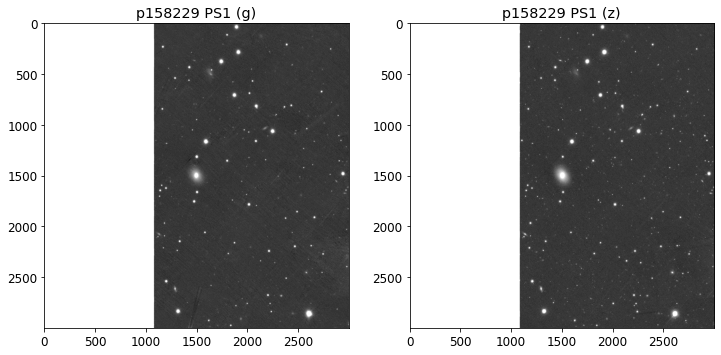

In [4]:
outFolder = PS_root + name + '/PS_Outputs_' + name + '/'
createDir(outFolder)
j_fits = galaxy_root + name + '/' + name + 'j.fits'
g_fits = PS_root + name + '/' + name + 'g.fits'
z_fits = PS_root + name + '/' + name + 'z.fits'
    
PS_mask = PS_root + name + '/' + name + '.mask'
if not os.path.exists(PS_mask):
    PS_mask = outFolder + '/' + name + '.mask' 
PS_lines = PS_root + name + '/' + name + 'ps.mask'
PS_skymask = configFolder + 'pssky.mask'
PS_circlemask = configFolder + 'pscircle.mask'
print("WFC3/IR file: ", j_fits)
print("PS files: ", g_fits, '  ', z_fits)

hdul = fits.open(j_fits)
hdr = hdul[0].header     # header

ra  = hdr["RA_TARG"]
dec = hdr["DEC_TARG"]

print("RA [deg]: ",  ra)
print("Dec [deg]: ", dec)

size = 3000   # size in pixels (0.25 arcsec/pixel)

gim = getgrayim(ra,dec,size=size,filter="g")
zim = getgrayim(ra,dec,size=size,filter="z")

pylab.rcParams.update({'font.size':12})
pylab.figure(1,(12,6))

pylab.subplot(121)
pylab.imshow(gim,origin="upper", cmap='gray')
pylab.title(name + ' PS1 (g)')

pylab.subplot(122)
pylab.title(name + ' PS1 (z)')
pylab.imshow(zim,origin="upper", cmap='gray')

### Looking up NED for Galaxtic Extinctions

Here, all we need is to have the coordinates of the galaxy

In [5]:
df_extinction = get_extinction(ra, dec)
df_extinction.set_index("Bandpass", inplace=True)

PS1_rows = [band for band in df_extinction.index.values if "PS1" in band]

df_extinction.loc[PS1_rows]

,Central Wavelength,The Galactic extinction,Refcode of the publications
Bandpass,,,
PS1 g,0.49,0.164,2011ApJ...737..103S
PS1 r,0.62,0.117,2011ApJ...737..103S
PS1 i,0.75,0.087,2011ApJ...737..103S
PS1 z,0.87,0.068,2011ApJ...737..103S
PS1 y,0.97,0.056,2011ApJ...737..103S
PS1 w,0.62,0.121,2011ApJ...737..103S


In [6]:
extinctions = df_extinction["The Galactic extinction"]

gext = extinctions["PS1 g"]
zext = extinctions["PS1 z"]

print("Galactic Extinction (PS1 g): ", gext)
print("Galactic Extinction (PS1 z): ", zext)

Galactic Extinction (PS1 g):  0.164
Galactic Extinction (PS1 z):  0.068


### Downloading PS1 files if they don't already exist

In [7]:
## downloading PS1 fits files 
def download_PS1(ra, dec, size, filter='g', format='fits', outFits="PS1.fits"):

    fitsurl = geturl(ra, dec, size=int(size), filters=filter, format=format)
    xcmd("curl '"+fitsurl[0]+"' -o "+outFits, verbose=False)
    print('Downloaded ... ' + outFits)

In [8]:
# if the original PS1 files do not exist, download them directly and use them
if not os.path.exists(g_fits):
    print('Could not find '+g_fits+'\n Downloading ...')
    g_fits = outFolder+"/"+name+"_g.fits"
    download_PS1(ra, dec, size, filter='g', outFits=g_fits)
if not os.path.exists(z_fits):
    print('Could not find '+z_fits+'\n Downloading ...')
    z_fits = outFolder+"/"+name+"_z.fits"
    download_PS1(ra, dec, size, filter='z', outFits=z_fits)

print("g-band fits file: " + g_fits)
print("z-band fits file: " + z_fits)

hdul = fits.open(g_fits)
hdr = hdul[0].header     # header
gexp = hdr["EXPTIME"]

hdul = fits.open(z_fits)
hdr = hdul[0].header     # header
zexp = hdr["EXPTIME"]

print("g-band exposure time (sec): " + str(gexp))
print("z-band exposure time (sec): " + str(zexp))

Could not find /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/p158229/p158229g.fits
Downloaded ... /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/p158229/PS_Outputs_p158229//p158229_g.fits
Could not find /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/p158229/p158229z.fits
Downloaded ... /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/p158229/PS_Outputs_p158229//p158229_z.fits
g-band fits file: /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/p158229/PS_Outputs_p158229//p158229_g.fits
z-band fits file: /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/p158229/PS_Outputs_p158229//p158229_z.fits
g-band exposure time (sec): 975.0
z-band exposure time (sec): 480.0


## Mask and residual image section

This next block is for making PanSTARRS masks using Source Extractor.
But these masks are always insufficient because they do not take out the stripes and defects.
They should be manually edited. Please edit the mask and rerun.

In [9]:
# create residual images for Source Extractor
monsta_script = """
    rd 1 '"""+g_fits+"""'
    rd 2 '"""+z_fits+"""'
    clip 1 nan=0
    clip 2 nan=0
    set nr="""+NR+"""/10$nint
    string nr '%i2.0' nr
    cop 3 1
    cop 4 2
    elliprof 3 model rmstar x0=1500 y0=1500 r0=7 r1="""+NR+""" nr=nr niter=5
    elliprof 4 model rmstar x0=1500 y0=1500 r0=7 r1="""+NR+""" nr=nr niter=5
    cop 5 1
    si 5 3
    cop 6 2
    si 6 4
    wd 5 '"""+outFolder+name+"""g.resid'
    wd 6 '"""+outFolder+name+"""z.resid'
    rd 10 '"""+PS_circlemask+"""'
    ac 5 500.
    ac 6 500.
    mi 5 10
    mi 6 10
    box 1 nc=550 nr=550 cc=1500 cr=1500
    wind 5 box=1
    wind 6 box=1
    wd 5 '"""+outFolder+name+"""g.zoom.resid'
    wd 6 '"""+outFolder+name+"""z.zoom.resid'
"""
run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


'OK'

In [10]:
# Run Source Extractor if needed to generate the mask.
monsta_script = """
    rd 7 '"""+outFolder+"""/psg.obj'
    rd 8 '"""+outFolder+"""/psz.obj'
    di 7 7
    di 8 8
    mi 8 7
    wd 8 '"""+outFolder+name+""".mask' bitmap
"""
sestring_g = outFolder+name+'g.resid -c '+configFolder+'psg.inpar -CATALOG_NAME '+outFolder+'psg.cat -PARAMETERS_NAME '+configFolder+'sbf.param -FILTER_NAME '+configFolder+'gauss_2.0_5x5.conv -STARNNW_NAME '+configFolder+'default.nnw -CHECKIMAGE_NAME '+outFolder+'psg.obj'
sestring_z = outFolder+name+'z.resid -c '+configFolder+'psz.inpar -CATALOG_NAME '+outFolder+'psz.cat -PARAMETERS_NAME '+configFolder+'sbf.param -FILTER_NAME '+configFolder+'gauss_2.0_5x5.conv -STARNNW_NAME '+configFolder+'default.nnw -CHECKIMAGE_NAME '+outFolder+'psz.obj'
# print(sestring_g)
# print(sestring_z)

if not os.path.exists(PS_mask):
    print('Could not find '+PS_mask)
    PS_mask = outFolder + name + '.mask'
    print('Making ' + PS_mask + ' now. Please edit it before proceeding.')
    ! sex {sestring_g}
    ! sex {sestring_z}
#    % sex """+outFolder+name+"""g.resid -c """+configFolder+"""psg.inpar -CATALOG_NAME """+outFolder+"""/psg.cat -CHECKIMAGE_NAME """+outFolder+"""/psg.obj
#    % sex """+outFolder+name+"""g.resid -c """+configFolder+"""psz.inpar -CATALOG_NAME """+outFolder+"""/psz.cat -CHECKIMAGE_NAME """+outFolder+"""/psz.obj
    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


In [11]:
# Multiply mask by line mask, if it exists
monsta_script = """
    rd 1 '"""+PS_mask+"""'
    rd 2 '"""+PS_lines+"""'
    mi 1 2
    wd 1 '"""+PS_mask+"""' bitmap
"""

if os.path.exists(PS_lines):
    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')

In [12]:
# Multiply residual images by mask for display
monsta_script = """
    rd 1 '"""+outFolder+name+"""g.resid'
    rd 2 '"""+outFolder+name+"""z.resid'
    rd 10 '"""+PS_mask+"""' bitmap 
    mi 1 10
    mi 2 10
    wd 1 '"""+outFolder+name+"""g.resid'
    wd 2 '"""+outFolder+name+"""z.resid'
    rd 10 '"""+PS_circlemask+"""'
    ac 1 500.
    ac 2 500.
    mi 1 10
    mi 2 10
    box 1 nc=550 nr=550 cc=1500 cr=1500
    wind 1 box=1
    wind 2 box=1
    wd 1 '"""+outFolder+name+"""g.zoom.resid'
    wd 2 '"""+outFolder+name+"""z.zoom.resid'
"""
run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


'OK'

In [13]:
# Source Extractor test cell - uncomment to see if SExtractor is working.
# ! sex {sestring_g}

Text(0.5, 1.0, 'Sky Mask')

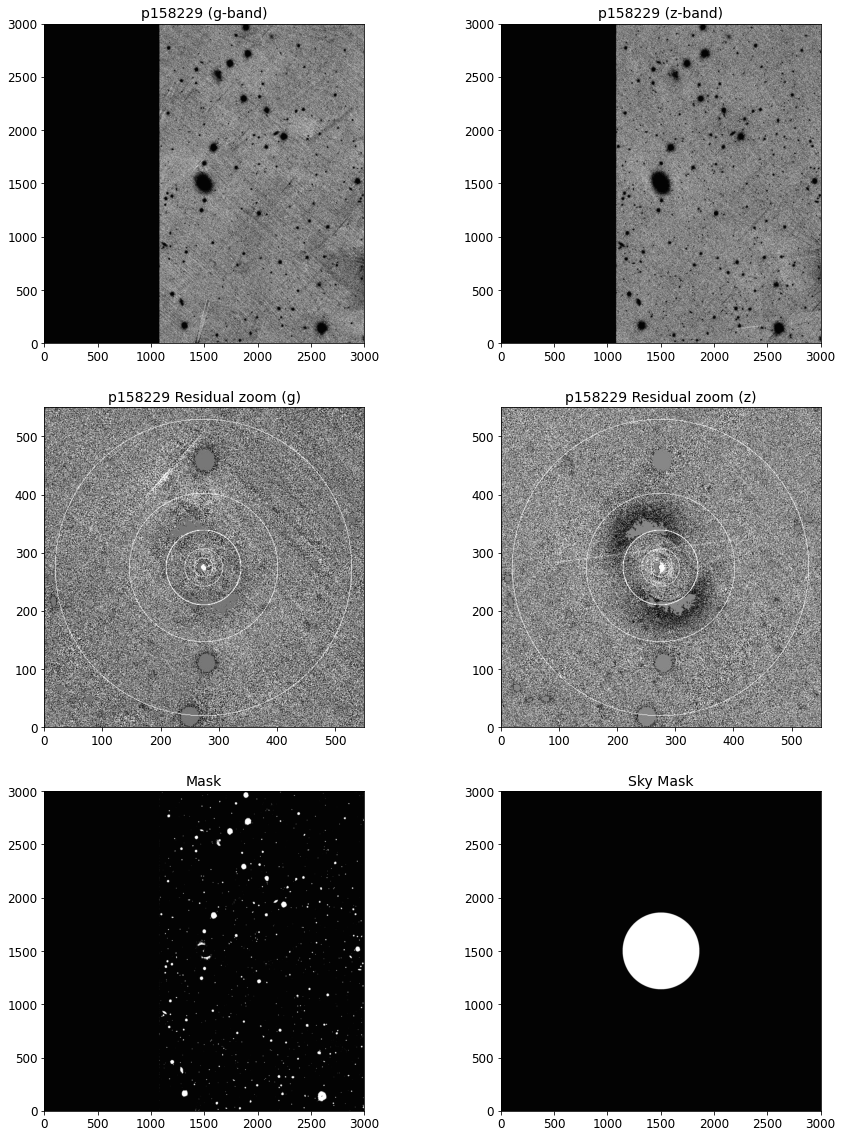

In [14]:
#PS_newmask = outFolder+name+".mask"

plt.figure(figsize=(15,20))

plt.subplot(321)
ax = plt.gca()
tv(g_fits,ax=ax, options='sqrt')
ax.set_title(name + " (g-band)", fontsize=14)

plt.subplot(322)
ax = plt.gca()
tv(z_fits,ax=ax, options='sqrt')
ax.set_title(name + " (z-band)", fontsize=14)

plt.subplot(325)
ax = plt.gca()
tv(PS_mask,ax=ax)
ax.set_title("Mask", fontsize=14)

plt.subplot(323)
ax = plt.gca()
tv(outFolder+name+"g.zoom.resid",ax=ax, options='')
ax.set_title(name + " Residual zoom (g)", fontsize=14)

plt.subplot(324)
ax = plt.gca()
tv(outFolder+name+"z.zoom.resid",ax=ax, options='')
ax.set_title(name + " Residual zoom (z)", fontsize=14)

plt.subplot(326)
ax = plt.gca()
tv(PS_skymask,ax=ax)
ax.set_title("Sky Mask", fontsize=14)


## Measure $(g-z)$

Unity = 0.012     Average radius =    24.8
Unity = 0.011     Average radius =    24.4
Unity = 0.024     Average radius =    46.4
Unity = 0.017     Average radius =    90.7
Unity = 0.005     Average radius =   195.9
Unity = 0.006     Average radius =   198.3
Unity = 0.007     Average radius =   196.4
Unity = 0.006     Average radius =   196.2
    
 SKYG    =   1.0053216246888041E-003
 SKYZ    =   3.1688853632658720E-003
    
 p158229 average (g-z) extinction corrected
    
 AVC0    =   1.3265223503112793     
 AVC1    =   1.3302760124206543     
 AVC2    =   1.3365921974182129     
 AVC5    =   1.3416629731655121     
 >> 

Text(0.5, 1.0, 'p158229 (g-z) color map')

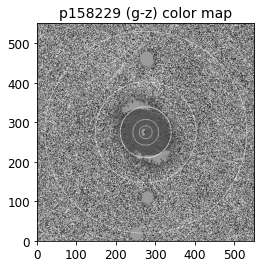

In [15]:
monsta_script = """
    string name '"""+name+"""'

    ! make the g-z color map
    rd 1 '"""+g_fits+"""'
    rd 2 '"""+z_fits+"""'
    clip 1 nan=0
    clip 2 nan=0
    dc 1 """+str(gexp)+"""
    dc 2 """+str(zexp)+"""
    cop 3 1
    cop 4 2
    rd 5 '"""+PS_skymask+"""'
    ! read the input PS mask; if it's not there, read the one that the notebook just made.
    rd 6 '"""+PS_mask+"""'
    mi 5 6
    mi 3 5
    mi 4 5
    cop 10 4
    ! sky values
    abx 3 all median median=skyg silent
    abx 4 all median median=skyz silent
    sc 1 skyg
    sc 2 skyz
    log 1
    mc 1 -2.5
    sc 1 """+str(gext)+"""
    log 2
    mc 2 -2.5
    sc 2 """+str(zext)+"""
    cop 3 1
    si 3 2
    wd 3 '"""+outFolder+name+"""gz.clr'
    cop 10 3
    mi 10 6
    ac 10 2
    rd 7 '"""+PS_circlemask+"""'
    mi 10 7
    box 1 nc=550 nr=550 cc=1500 cr=1500
    wind 10 box=1
    wd 10 '"""+outFolder+name+"""gz.zoom.clr'
    close 7
    
    ! measure the (g-z) values
    cop 1 3
    mi 1 6
    close 6
    open 2 nr=512 nc=512
    fluc 2 1 mask x0=1500 y0=1500 r0=15.9 r1=31.8 a0=0 a1=360 ! c0
    abx 2 all median=median medrms=rms silent
    ! typ median,rms
    set max=2*rms+median
    set min=-2*rms+median
    ! typ min,max
    clip 1 max=max vmax=0 min=min vmin=0
    close 2
    ! open 2 nr=512 nc=512
    ! fluc 2 1 mask x0=1500 y0=1500 r0=15.9 r1=127 a0=0 a1=360 ! cc
    open 3 nr=512 nc=512
    fluc 3 1 mask x0=1500 y0=1500 r0=15.9 r1=31.8 a0=0 a1=360 ! c0
    open 4 nr=512 nc=512
    fluc 4 1 mask x0=1500 y0=1500 r0=31.8 r1=63.5 a0=0 a1=360 ! c1
    open 5 nr=512 nc=512
    fluc 5 1 mask x0=1500 y0=1500 r0=63.5 r1=127 a0=0 a1=360 ! c2
    open 6 nr=512 nc=512
    fluc 6 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=0 a1=90 ! nw
    open 7 nr=512 nc=512
    fluc 7 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=90 a1=180 ! sw
    open 8 nr=512 nc=512
    fluc 8 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=180 a1=270 ! se
    open 9 nr=512 nc=512
    fluc 9 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=270 a1=360 ! ne

    ! medians
    ! abx 2 all median median=medcc medrms=medccrms silent
    abx 3 all median median=medc0 medrms=medc0rms silent
    abx 4 all median median=medc1 medrms=medc1rms silent
    abx 5 all median median=medc2 medrms=medc2rms silent
    abx 6 all median median=mednw medrms=mednwrms silent
    abx 7 all median median=medsw medrms=medswrms silent
    abx 8 all median median=medse medrms=medserms silent
    abx 9 all median median=medne medrms=mednerms silent

    ! do in the same regions as we do SBF measurements
    set medc5=mednw+medsw+medse+medne/4
    printf ' '
    typ skyg,skyz
    ! printf ' '
    ! printf '{name} median (g-z) extinction corrected'
    ! printf ' '
    ! typ medc0,medc1,medc2,medc5
    ! printf '{name} (g-z) rms values'
    ! typ medc0rms,medc1rms,medc2rms,mednerms

    ! averages
    ! abx 2 all mean=avcc rms=avccrms silent
    abx 3 all mean=avc0 rms=avc0rms silent
    abx 4 all mean=avc1 rms=avc1rms silent
    abx 5 all mean=avc2 rms=avc2rms silent
    abx 6 all mean=avnw rms=avnwrms silent
    abx 7 all mean=avsw rms=avswrms silent
    abx 8 all mean=avse rms=avserms silent
    abx 9 all mean=avne rms=avnerms silent
    set avc5=avnw+avsw+avse+avne/4
    printf ' '
    printf '{name} average (g-z) extinction corrected'
    printf ' '
    typ avc0,avc1,avc2,avc5
    ! printf '{name} (g-z) rms values' 
    ! typ avc0rms,avc1rms,avc2rms,avnerms

"""

run_monsta(monsta_script, 'monsta.pro', 'monsta.log')
!cat monsta.log

ax = plt.gca()
tv(outFolder+name+"gz.zoom.clr",ax=ax, options='0 5')
ax.set_title(name + " (g-z) color map", fontsize=14)

In [16]:
# clean up temporary display images
temp = outFolder+name+'*.zoom.*'
!rm {temp}

## Saving the color information

In [17]:
with open("monsta.log", "r") as f:
    lines = f.readlines()

In [18]:
import json

outdict = {}
radii = []
outdict["Radii"] = radii

for l in lines:
    l0 = l.strip()
    l00 = l0.split()
    
    if l00:

        if "Unity" in l0:
            radii.append({"Unity": float(l00[2]), "Average_radius": float(l00[6])})

        if "SKY" in l00[0] or "AV" in l00[0]:
            outdict[l00[0]] = float(l00[2])

        if "extinction" in l0:
            outdict["name"] = l00[0]
        


json_name = outFolder+name+"_color_ps_gz.json"
with open(json_name, 'w') as file:
    json_string = json.dumps(outdict, default=lambda o: o.__dict__, sort_keys=True, indent=2)
    file.write(json_string)
    
    print("Colors are stored in: ", json_name)
    


Colors are stored in:  /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/p158229/PS_Outputs_p158229/p158229_color_ps_gz.json


## The content of the color json file:

In [19]:
!cat {json_name}

{
  "AVC0": 1.3265223503112793,
  "AVC1": 1.3302760124206543,
  "AVC2": 1.336592197418213,
  "AVC5": 1.341662973165512,
  "Radii": [
    {
      "Average_radius": 24.8,
      "Unity": 0.012
    },
    {
      "Average_radius": 24.4,
      "Unity": 0.011
    },
    {
      "Average_radius": 46.4,
      "Unity": 0.024
    },
    {
      "Average_radius": 90.7,
      "Unity": 0.017
    },
    {
      "Average_radius": 195.9,
      "Unity": 0.005
    },
    {
      "Average_radius": 198.3,
      "Unity": 0.006
    },
    {
      "Average_radius": 196.4,
      "Unity": 0.007
    },
    {
      "Average_radius": 196.2,
      "Unity": 0.006
    }
  ],
  "SKYG": 0.0010053216246888041,
  "SKYZ": 0.003168885363265872,
  "name": "p158229"
}